# Testing Generalized Fisherface on Tufts Dataset

## Set up

In [1]:
import numpy as np
import sklearn.pipeline
import matplotlib.pyplot as plt

In [2]:
# load data
tufts_dataset = np.load('data/tufts_face_dataset.npy', allow_pickle=True).item()
X = tufts_dataset['X']
y = tufts_dataset['Y']
expressions = tufts_dataset['expressions']

n_samples, h, w = np.shape(X)
X = np.array([img.flatten() for img in X])
n_features = X.shape[1]
n_classes = len(np.unique(y))

print("Total dataset size:")
print("n_samples: ",  n_samples)
print('image_shape: ', (h,w))
print("n_features: ", n_features)
print("n_classes: ", n_classes)



# split into a training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, exp_train, exp_test = train_test_split(X, y, expressions, test_size=0.25, random_state=314159, stratify=y)

# first, scale the data
scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train_trfm = scaler.transform(X_train)
X_test_trfm = scaler.transform(X_test)

n_samples_train = len(X_train)
print('n_samples_train', n_samples_train)

Total dataset size:
n_samples:  560
image_shape:  (92, 61)
n_features:  5612
n_classes:  112
n_samples_train 420


In [3]:
def plot_faces(faces, n_cols=3, figsize=(8,6), h=h, w=w):

    dim, n_faces = faces.shape
    n_rows = n_faces // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(faces[:, i].reshape(h,w))

    return fig, ax

In [4]:
from generalized_fisher_ld import GeneralizedFisherLD

## Generalized Fisherface ($\alpha = \beta = 0$)

For $\alpha=\beta=0$, we reduce to standard fisherface. Recall that for standard fisherface, we first need to perform PCA to avoid singular matrices in the generalized eigenvector problem.

In [5]:
import sklearn.pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

fld_clf = sklearn.pipeline.Pipeline(steps=[('pca', PCA(n_components = n_samples_train - n_classes)),
                                           ('fld', GeneralizedFisherLD(n_components=n_classes - 1, alpha=0)),
                                           ('rf', RandomForestClassifier())])
fld_clf.fit(X_train_trfm, y_train)

fisherfaces = (fld_clf[1].transformation_matrix_ @ fld_clf[0].components_).T

(<Figure size 576x432 with 6 Axes>, <AxesSubplot:>)

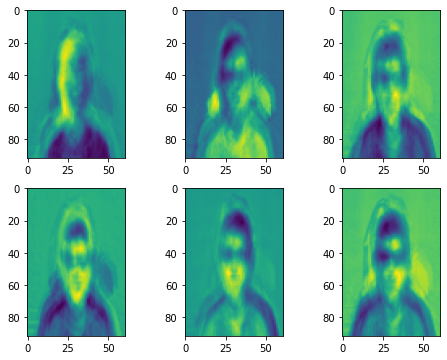

In [6]:
plot_faces(fisherfaces[:,:6])

In [7]:
print('train acc: ', fld_clf.score(X_train_trfm, y_train))
print('test acc: ', fld_clf.score(X_test_trfm, y_test))

train acc:  1.0
test acc:  0.8928571428571429


## Generalized Fisherface ($\alpha=\beta=1$)

For $\alpha = \beta = 1$ we reduce to standard PCA (and hence standard eigenface). Note that we don't need to initially perform PCA to avoid singular matrices for the generalized eigenvector calculation.

In [8]:
import sklearn.pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

fld_clf = sklearn.pipeline.Pipeline(steps=[('fld', GeneralizedFisherLD(n_components=n_classes - 1, alpha=1, beta=1)),
                                           ('rf', RandomForestClassifier())])
fld_clf.fit(X_train_trfm, y_train)

fisherfaces = fld_clf[0].transformation_matrix_

(<Figure size 576x432 with 6 Axes>, <AxesSubplot:>)

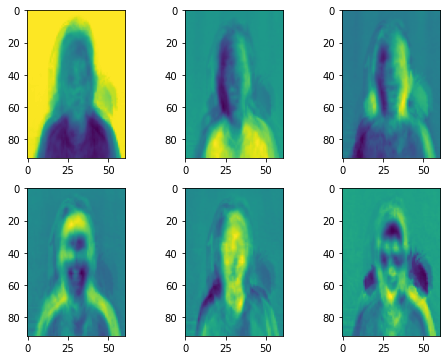

In [9]:
plot_faces(fisherfaces[:,:6])

In [10]:
print('train acc: ', fld_clf.score(X_train_trfm, y_train))
print('test acc: ', fld_clf.score(X_test_trfm, y_test))

train acc:  1.0
test acc:  0.9571428571428572


In [11]:
# quickly compare against eigenface (very similar performance!)
import sklearn.pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

eigenface = sklearn.pipeline.Pipeline(steps=[('pca', PCA(n_components=n_classes - 1)),
                                           ('rf', RandomForestClassifier())])
eigenface.fit(X_train_trfm, y_train)

print('train acc: ', eigenface.score(X_train_trfm, y_train))
print('test acc: ', eigenface.score(X_test_trfm, y_test))

train acc:  1.0
test acc:  0.9571428571428572


## Generalized Fisherface ($\alpha=\beta=0.5$)

We now test intermediate values of $\alpha$ and $\beta$. Note that we still don't have to perform PCA first to avoid singular matrices!

In [12]:
import sklearn.pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

fld_clf = sklearn.pipeline.Pipeline(steps=[('fld', GeneralizedFisherLD(n_components=n_classes - 1, alpha=0.5, beta=0.5)),
                                           ('rf', RandomForestClassifier())])
fld_clf.fit(X_train_trfm, y_train)

fisherfaces = fld_clf[0].transformation_matrix_

(<Figure size 576x432 with 6 Axes>, <AxesSubplot:>)

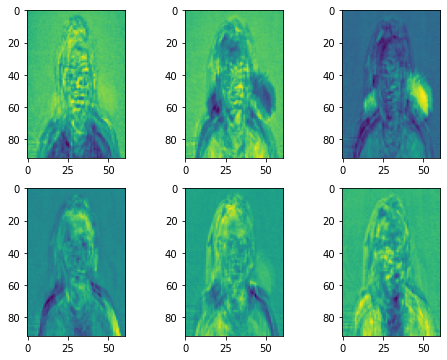

In [13]:
plot_faces(fisherfaces[:,:6])

In [14]:
print('train acc: ', fld_clf.score(X_train_trfm, y_train))
print('test acc: ', fld_clf.score(X_test_trfm, y_test))

train acc:  1.0
test acc:  0.95


Note that $\alpha=0.5$ is significantly better than both $\alpha=\beta=1$ (standard eigenface) and $\alpha=\beta=0$ (standard fisherface)! This indicates that this generalization has value.

## More detailed evaluation

In [15]:
alpha_betas = np.linspace(0,1, num=51)

train_accs = []
test_accs = []

within_class_scatter = []
between_class_scatter = []
scatter_ratio = []

In [17]:
from tqdm import tqdm

# skip first because fisherface requires initial pca
for alpha_beta in tqdm(alpha_betas):
    alpha = beta = alpha_beta

    # if alpha=beta=0 (standard fisherface, need to do pca first)
    if alpha == beta == 0:
        fld_clf = sklearn.pipeline.Pipeline(steps=[('pca', PCA(n_components = n_samples_train - n_classes)),
                                           ('fld', GeneralizedFisherLD(n_components=n_classes - 1, alpha=0)),
                                           ('rf', RandomForestClassifier())])

        fld_clf.fit(X_train_trfm, y_train)

        within_class_scatter.append(fld_clf[1].within_class_scatter())
        between_class_scatter.append(fld_clf[1].between_class_scatter())
    else:
        fld_clf = sklearn.pipeline.Pipeline(steps=[('fld', GeneralizedFisherLD(n_components=n_classes - 1, alpha=alpha, beta=beta)),
                                                    ('rf', RandomForestClassifier())])

        fld_clf.fit(X_train_trfm, y_train)

        within_class_scatter.append(fld_clf[0].within_class_scatter())
        between_class_scatter.append(fld_clf[0].between_class_scatter())


    train_accs.append(fld_clf.score(X_train_trfm, y_train))
    test_accs.append(fld_clf.score(X_test_trfm, y_test))



100%|██████████| 51/51 [1:50:52<00:00, 130.44s/it]


In [18]:
import pandas as pd
data_dict = {'alpha': alpha_betas, 'beta': alpha_betas, 'train_acc': train_accs, 'test_acc': test_accs,
             'within_scatter': within_class_scatter, 'between_scatter': between_class_scatter}

gfld_df = pd.DataFrame(data_dict)

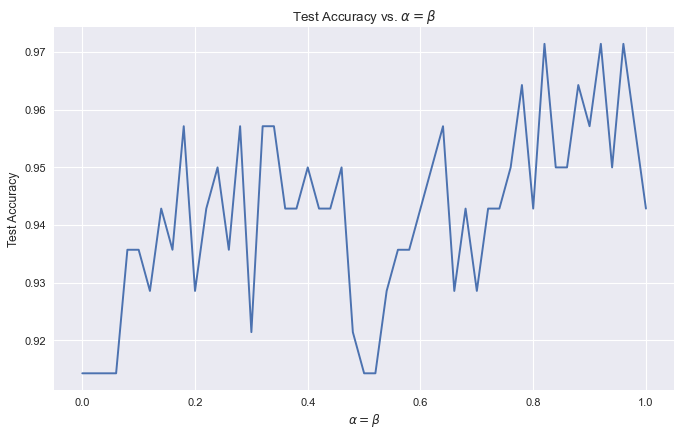

In [19]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,6), dpi=80);
ax.plot(alpha_betas, test_accs);
ax.set_title('Test Accuracy vs. $\\alpha = \\beta$');
ax.set_xlabel('$\\alpha=\\beta$');
ax.set_ylabel('Test Accuracy');

## Cross-Validation Grid Search over $\alpha$ and $\beta$

In [20]:
from sklearn.model_selection import GridSearchCV

In [ ]:
fld_clf = sklearn.pipeline.Pipeline(steps=[('fld', GeneralizedFisherLD(n_components=n_classes - 1)),
                                           ('rf', RandomForestClassifier())])

# TODO: test with finer grid. (just takes longer)
param_grid = {
    "fld__alpha": np.linspace(0.1, 1, num=4), # excluding alpha=0 because that is a special case
    "fld__beta": np.linspace(0.1, 1, num=4),
}

cv_gridsearch = GridSearchCV(fld_clf, param_grid, cv=5, n_jobs=-1, verbose=1)
cv_gridsearch.fit(X_train_trfm, y_train)

In [ ]:
cv_gridsearch.best_params_

In [ ]:
cv_gridsearch.best_score_